# Evaluating KNetworks

In [1]:
import matplotlib.pyplot as plt

from knetworks import knetworks, Network
import numpy as np
from testdata.generator import generateFromGenFile
import torch
import os

from sklearn.model_selection import KFold

%matplotlib inline

%config InlineBackend.figure_format='retina'
if torch.cuda.is_available():
	train_on = "cuda"
else:
	train_on = "cpu"
device = torch.device("cuda") # I AM SPEEEEED

## Read in the features and the user data
We use a dataset of 19 users and over 500 shopping lists.

In [2]:
filename = os.getcwd() + "/../" + "allproducts2.txt" #may not work for windows
with open(filename, "r") as file:
    f = file.read()
    products = f.split("\n")

products = [p.upper() for p in products]

features = []
vectors = []
data = [[] for i in range(19)] # warning #cleancode
for f in range(1, 20):
    file = open("testdata/gu_" + str(f) + ".txt", "r") 
    lines = file.readlines()
    features = sorted(str(lines[0]).replace(" ", "").upper().strip().split(","))
    vect = []
    for l in range(len(lines)-1):
        data[f-1].append([])
        vec = lines[l+1].upper().split(",")
        for i in range(len(vec)):
            if int(float(vec[i])) == 1:
                data[f-1][l].append(features[i])
    vectors.append(np.array(vect))
    
vectors = np.array([np.array([np.zeros(len(products), dtype=np.int) for gr_list in range(len(data[user]))]) for user in range(len(data))])
for i,x in enumerate(data):
    for j,y in enumerate(x):
        for k,f in enumerate(products):
            if f in y:
                vectors[i][j][k] = 1

<ipython-input-2-dde063293636>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  vectors = np.array([np.array([np.zeros(len(products), dtype=np.int) for gr_list in range(len(data[user]))]) for user in range(len(data))])


## Kmeans Test
This cell plots a scatter plot with two features of the users and the calculated centroids.

In [3]:
i_butter = products.index("BUTTER")
i_apple = products.index("APFEL")
meanVecs = []
for u in vectors:
    meanVec = np.mean(u, axis=0)
    meanVecs.append(meanVec)
meanVecs = np.array(meanVecs)
meanVecs.shape
plt.scatter(meanVecs[:,i_butter], meanVecs[:,i_apple], marker="x", s=90, c=knet.km.affiliations)
plt.xlabel("bought butter")
plt.ylabel("bought apple(s)")
plt.scatter(knet.km.centroids[:,i_butter], knet.km.centroids[:,i_apple], c=[0,1,2,3,4,5])#why is the purple dot not in the middle of the purple crosses?

NameError: name 'knet' is not defined

## The eval functions
The following are functions used to evaluate the performance of the trained model.

In [3]:
def eval1(knet):
    r_gs = []
    f_ps = []
    f_ns = []
    t_ps = []
    predictions = []
    n = len(products)
    for user in range(19):
        prediction = np.array(np.squeeze(knet.predict(vectors[user][:-4,:], future=1))) # the prediction for user
        wrong_guesses = np.sum(np.absolute((np.absolute(np.round(prediction)) - vectors[user][-4,:]))) # the right guessed features for one receipt into the future
        false_postives = np.sum(np.maximum((np.absolute(np.round(prediction)) - vectors[user][-4,:]), 0))
        false_negatives = np.sum(np.maximum((vectors[user][-4,:] - np.absolute(np.round(prediction))), 0))
        true_positives = np.sum((np.round(prediction) + vectors[user][-4,:])//2)
        right_guesses = n - wrong_guesses
        true_negatives = right_guesses - true_positives
        r_gs.append(right_guesses)
        f_ps.append(false_postives)
        f_ns.append(false_negatives)
        t_ps.append(true_positives)
        predictions.append(prediction)
        
        predictfourlast = np.array(np.squeeze(knet.predict(vectors[user][:-8,:], future=4)))
        predictionfourlasts.append(predictfourlast)
        #print(false_postives, false_negatives)
        #print("["+ str(user) + "] Accuracy: " + str(len(products)-int(wrong_guesses)) + "/" + str(len(products)) + " (" + str((len(products)-int(wrong_guesses))/len(products)) + ")")
    m_r_gs = np.mean(r_gs)
    m_f_ps = np.mean(f_ps)
    m_f_ns = np.mean(f_ns)
    m_t_ps = np.mean(t_ps)
    acc = m_r_gs / n
    recall = m_t_ps / (m_t_ps + m_f_ns)
    precision = m_t_ps / (m_t_ps + m_f_ps)
    print("TP,FP,FN: ", m_t_ps, m_f_ps, m_f_ns)
    print("Accuracy: ", acc)
    print("True positive rate (recall) (correctly predicted of all YES values): ", recall)
    print("Precision (correctly predicted of all YES predicted): ", precision)
    return acc, recall, precision, predictions

In [4]:
def eval2(knet, u1=0, u2=19):
    r_gs = []
    f_ps = []
    f_ns = []
    t_ps = []
    predictions = []
    n = len(products)
    for user in range(u1,u2):
        prediction = np.array(np.squeeze(knet.predict(vectors[user][:-5,:], future=1)+0.15)) # the prediction for user
        wrong_guesses = np.sum(np.absolute((np.absolute(np.round(prediction)) - vectors[user][-5,:]))) # the right guessed features for one receipt into the future
        false_postives = np.sum(np.maximum((np.absolute(np.round(prediction)) - vectors[user][-5,:]), 0))
        false_negatives = np.sum(np.maximum((vectors[user][-5,:] - np.absolute(np.round(prediction))), 0))
        true_positives = np.sum((np.round(prediction) + vectors[user][-5,:])//2)
        right_guesses = n - wrong_guesses
        true_negatives = right_guesses - true_positives
        r_gs.append(right_guesses)
        f_ps.append(false_postives)
        f_ns.append(false_negatives)
        t_ps.append(true_positives)
        predictions.append(prediction)
        
        predictfourlast = np.array(np.squeeze(knet.predict(vectors[user][:-8,:], future=4)))
        predictionfourlasts.append(predictfourlast)
        #print(false_postives, false_negatives)
        #print("["+ str(user) + "] Accuracy: " + str(len(products)-int(wrong_guesses)) + "/" + str(len(products)) + " (" + str((len(products)-int(wrong_guesses))/len(products)) + ")")
    m_r_gs = np.mean(r_gs)
    m_f_ps = np.mean(f_ps)
    m_f_ns = np.mean(f_ns)
    m_t_ps = np.mean(t_ps)
    acc = m_r_gs / n
    recall = m_t_ps / (m_t_ps + m_f_ns)
    precision = m_t_ps / (m_t_ps + m_f_ps)
    print("TP,FP,FN: ", m_t_ps, m_f_ps, m_f_ns)
    print("Accuracy: ", acc)
    print("True positive rate (recall) (correctly predicted of all YES values): ", recall)
    print("Precision (correctly predicted of all YES predicted): ", precision)
    return acc, recall, precision, predictions

## Testing KNetworks
The following function trains KNetworks with $k=1\dots15$ and plots the performances.
We divide the dataset in a training (`vectors[:][:-4,:]`) and a test (`vectors[:][-4:,:]`) dataset. 
The four last list of every user are not feeded into the network during training and are beeing predicted. 
The `eval1()` function evaluates the model based on this prediction.

In [6]:
performances = []
predictions = []
predictionfourlasts = []

In [6]:
def test_diffrent_ks():
    for i in [1,2,3,4,5,6,7,8,10,12,15]:
        knet = knetworks(i, vectors[:][:-4][:], len(products), device)
        knet.fit()
        knet.train(round(500/np.sqrt(i)),1)#not the same amount for every network, to be a little more fair
        #training time is now O(sqrt(k))
        print("k: ", i)
        acc, rec, prec, preds = eval1(knet)
        print("\n")
        performances.append([i,acc,rec,prec])
        predictions.append(preds)
        torch.cuda.empty_cache()
    return np.array(performances)

In [ ]:
performances = test_diffrent_ks()

In [72]:
# calulate the confidence
confidencess =  []
for k in range(11):
    confidences = []
    for user in range(19):
        pos = predictions[k][user][np.round(predictions[k][user]) == 1]
        if len(pos) > 0:
            confidences.append(np.sum(pos) / len(pos))
    #print("k =", k ,":", np.sum(np.array(confidences)) / len(confidences))
    confidencess.append(np.sum(np.array(confidences)) / len(confidences))

In [73]:
def plot_performances(performances):
    plt.plot(performances[:,0], performances[:,1])
    plt.plot(performances[:,0], performances[:,2])
    plt.plot(performances[:,0], performances[:,3])
    plt.plot(performances[:,0], confidencess)
    plt.xlabel("k")
    plt.legend(['Accuracy', 'Recall', "Precision", "Confidence"], loc=4)
    plt.savefig("performances.png")
    plt.show()

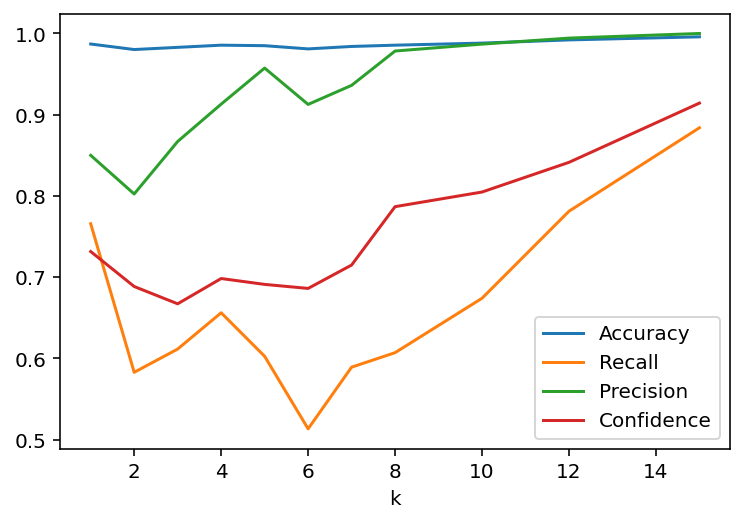

In [74]:
plot_performances(np.array(performances))

In [83]:
predictionfourlasts = np.array(predictionfourlasts).reshape(11,19,4,333)

In [87]:
def plotForK(k):
    f, axes = plt.subplots(19, 5, figsize=(8, 12))
    X1 = np.linspace(0, 5, 5)
    X2 = np.linspace(0, 4, 4)
    X3 = np.linspace(3, 5, 2)
    X4 = np.linspace(0,5,5)
    for user in range(19):
        summ = np.sum(np.round(predictionfourlasts[k][user]), axis=0)
        interests = np.where(summ > 0)
        for j in range(5):
            future = predictions[k][user][j]
            if len(interests[0]) >= 5:
                predictionsFour = np.append(predictionfourlasts[k][user][:,interests[0][j]], future)
                gt = vectors[user][-8:-3,interests[0][j]]
            else:
                predictionsFour = np.append(predictionfourlasts[k][user][:,j], future)
                gt = vectors[user][-8:-3,j]



            axes[user][j].plot(X1, predictionsFour, c="green")
            axes[user][j].plot(X1, gt, c="red")
            axes[user][j].axvline(4, 0, 1)
            axes[user][j].plot(X1, np.round(predictionsFour), c="purple")
    f.legend(['Predictions', 'Ground truth', 'End of training dataset', 'Rounded prediction'], bbox_to_anchor=(0., 0, 1, .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)
    
    f.savefig(str(k) + "_plot.png")
        

In [ ]:
for k in range(11):
    plotForK(k)

## Testing KNetworks using cross-validation (KFold) (TODO)

In [7]:
X = [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19]
kf = KFold(n_splits=8, random_state=None, shuffle=False)

In [8]:
folds = []
tests = []

In [9]:
for train_index, test_index in kf.split(X):
    folds.append(train_index)
    tests.append(test_index)
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [0 1 2]
TRAIN: [ 0  1  2  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [3 4 5]
TRAIN: [ 0  1  2  3  4  5  9 10 11 12 13 14 15 16 17 18] TEST: [6 7 8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 11 12 13 14 15 16 17 18] TEST: [ 9 10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 13 14 15 16 17 18] TEST: [11 12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 15 16 17 18] TEST: [13 14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 18] TEST: [15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18]


In [ ]:
for fold, test in zip(folds, tests):
    print("test:", test[0], "-" , test[-1])
    knet = knetworks(8, vectors[:test[0]][:-4], len(products), device)
    knet.fit()
    knet.train(500,1)
    for t in test:
        eval2(knet, t, t+1)
        print("\n")
    eval1(knet)
#knet.save("saves")

# Training a good model for the webapp

In [5]:
knet = knetworks(7, vectors, len(products), device)
knet.fit()
knet.train(500,1)
knet.save("saves")

[6][499->0] Training....

